# Imports

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


# 1D Poisson Equation



$$\frac{d^2 u}{dx^2} = f(x), \quad x \in (0, 1) \text{ with boundary conditions: $u(0)=0$ and $u(1)=1$}$$

The analytical solution: $u^*(x) = \sin(\pi x)$  
  
The source function: $f(x) = -\pi^2 \sin(\pi x)$

For simplicity of this problem, we denote the input as X and output as Y

## Define PDE & Simulate noisy data

In [21]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [22]:
data_noise = 0.08

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

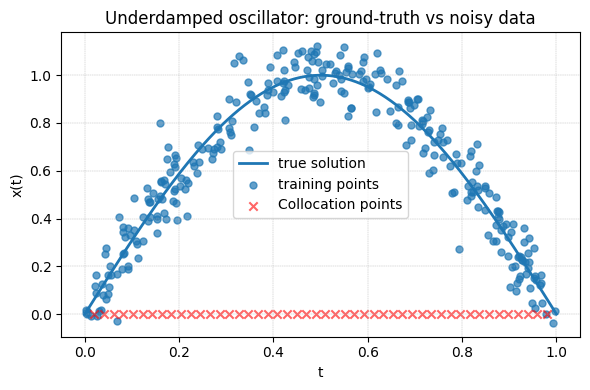

In [23]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

**Parameters for tuning prediction spread:**

- `rho`: define the Bayesian Layer parameters' spread
  
- `piror_std`: define the piror distribution's std
- `data_noise_guess`: define the guessed data noise in the loss function - negative log likelihood

In [24]:
# from draft import VIBPINN

vi_poisson_model = VIBPINN(pde, 1, [16, 32, 32, 16], 1, mu_std=0.05, rho=-3, prior_std=1000.0, init_data_noise=0.01, learn_data_noise=True)
loss_dict = vi_poisson_model.fit_vi_bpinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=20000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0, λ_elbo=1.0)

ep     0 | L=7.16e+05 | elbo=7.13e+05 | pde=2.28e+03  ic=0.00e+00  bc=7.03e-03 | lr=3.00e-03 | learned noise_std=1.000e-02
ep     1 | L=7.23e+05 | elbo=7.21e+05 | pde=2.28e+03  ic=0.00e+00  bc=1.50e-02 | lr=3.00e-03 | learned noise_std=1.003e-02
ep   200 | L=8.70e+04 | elbo=8.48e+04 | pde=2.27e+03  ic=0.00e+00  bc=6.53e-01 | lr=3.00e-03 | learned noise_std=1.369e-02
ep   400 | L=6.06e+04 | elbo=5.83e+04 | pde=2.27e+03  ic=0.00e+00  bc=9.03e-01 | lr=3.00e-03 | learned noise_std=1.750e-02
ep   600 | L=3.69e+04 | elbo=3.46e+04 | pde=2.27e+03  ic=0.00e+00  bc=5.50e-01 | lr=3.00e-03 | learned noise_std=2.144e-02
ep   800 | L=2.70e+04 | elbo=2.48e+04 | pde=2.27e+03  ic=0.00e+00  bc=5.62e-01 | lr=3.00e-03 | learned noise_std=2.543e-02
ep  1000 | L=2.05e+04 | elbo=1.83e+04 | pde=2.27e+03  ic=0.00e+00  bc=7.72e-01 | lr=3.00e-03 | learned noise_std=2.947e-02
ep  1200 | L=1.64e+04 | elbo=1.41e+04 | pde=2.27e+03  ic=0.00e+00  bc=7.39e-01 | lr=3.00e-03 | learned noise_std=3.352e-02
ep  1400 | L=1.3

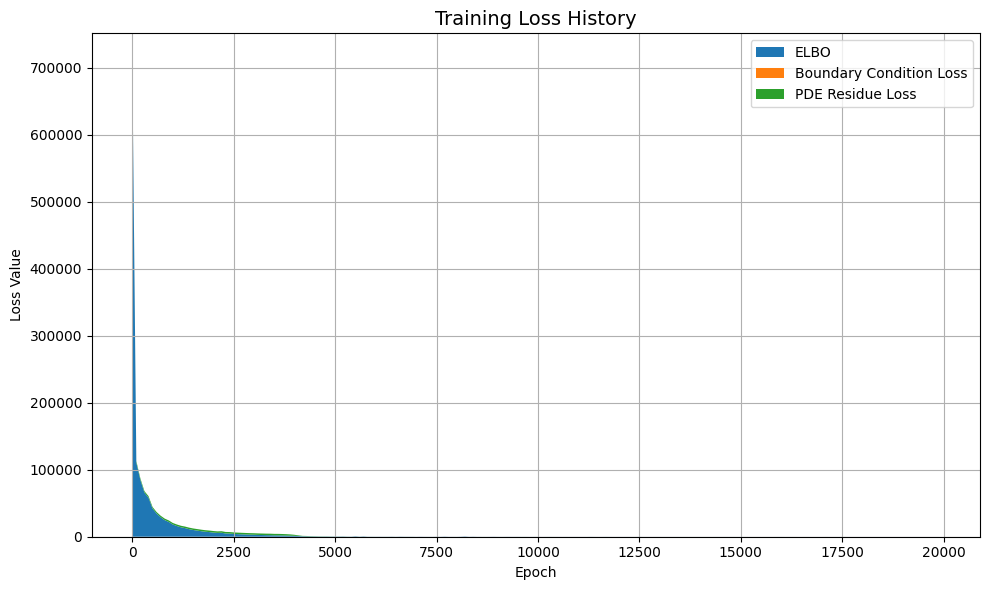

In [25]:
plot_training_history(loss_dict, plot_after=0, step=100)

In [26]:
x_grid = torch.linspace(0, 1, 100).view(-1, 1)
pred_set = vi_poisson_model.predict(x_grid, n_samples=1000, z_score=1.96)

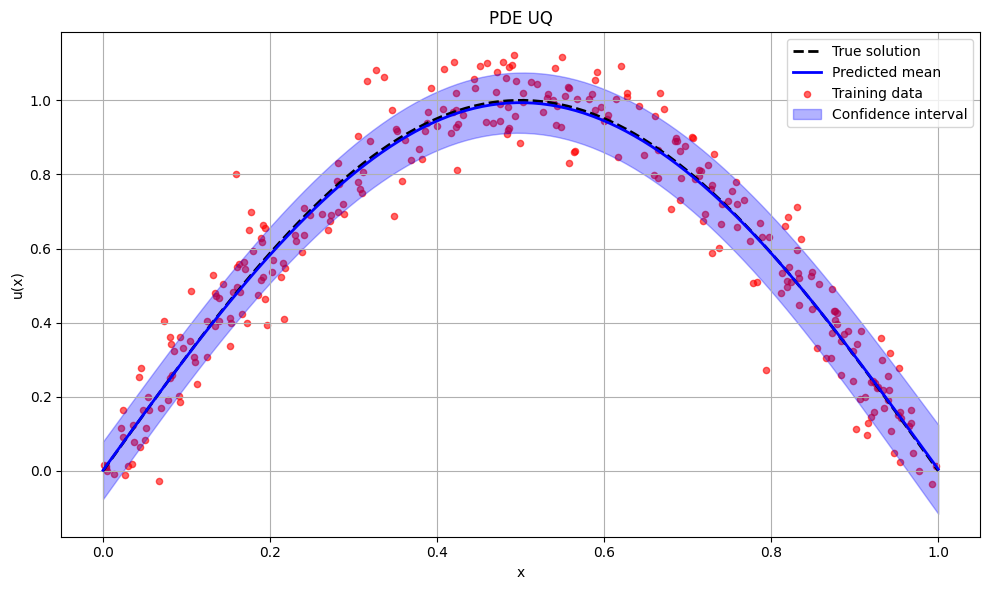

In [27]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_train, Y=Y_train)

## Sharpness & Coverage 

In [28]:
from utils_result_metrics import test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = test_uncertainties(vi_poisson_model, alphas, X_test, Y_test)

100%|██████████| 8/8 [00:00<00:00, 94.80it/s]


In [29]:
rslt

,alpha,coverage,sharpness
0,0.111111,0.68,0.150621
1,0.222222,0.40,0.101859
2,0.333333,0.44,0.098883
3,0.444444,0.29,0.068747
4,0.555556,0.20,0.051841
5,0.666667,0.13,0.036770
6,0.777778,0.10,0.025513
7,0.888889,0.06,0.011844


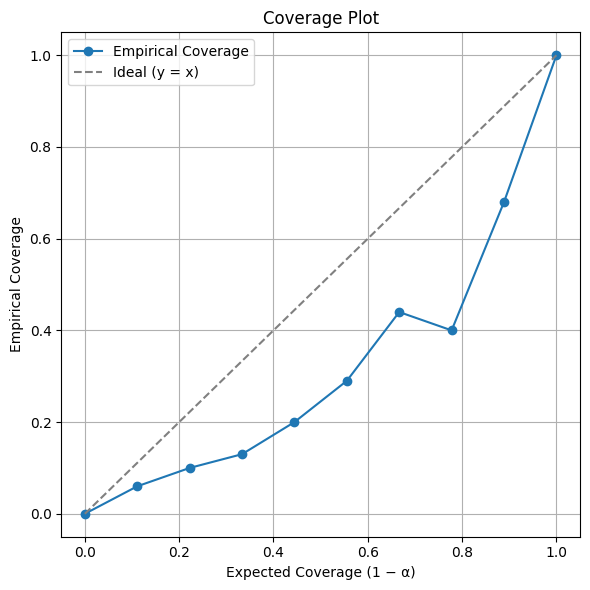

In [30]:
from utils_result_viz import plot_expected_vs_empirical

plot_expected_vs_empirical(rslt)

## Uncertainty Plot


In [31]:
def plot_uncertainty(pred_set, x_grid):
    """
    Plot the uncertainty (interval width) over the grid.

    Parameters:
    - pred_set: tuple or list containing (lower_bounds, upper_bounds)
    - x_grid: 1D array of x values (same length as pred_set[0] and pred_set[1])
    """
    lower_bounds = np.array(pred_set[0])
    upper_bounds = np.array(pred_set[1])
    uncertainty = (upper_bounds - lower_bounds)

    plt.figure(figsize=(8, 5))
    plt.plot(x_grid, uncertainty, label='Uncertainty Width')
    plt.xlabel('x')
    plt.ylabel('Prediction Interval Width')
    plt.title('Uncertainty Across Input Grid')
    plt.grid(True)
    plt.legend()
    plt.show()


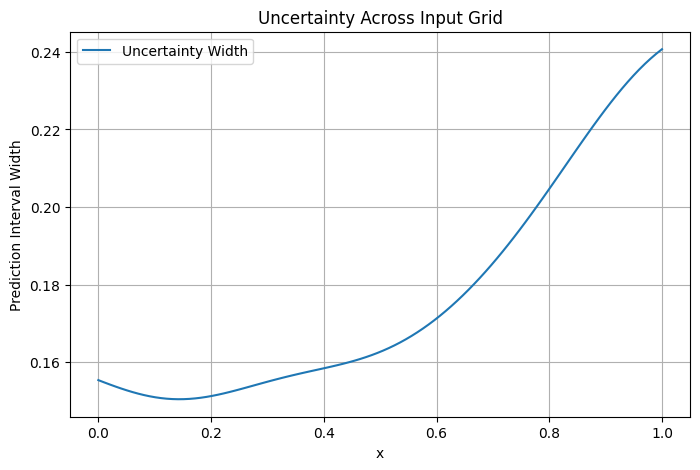

In [32]:
plot_uncertainty(pred_set, x_grid)